In [ ]:
### Check if GPU is available ###
!nvidia-smi

# Import Libraries

In [160]:
import os
import sys
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt

# For progression bar
from tqdm import tqdm

### PyTorch dependencies ###
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms
import torchvision.utils as vutils

### Some constants ###
H, W, C = 64, 64, 3
LATENT_DIM = 128
filters = 64

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Loading and processing data for training

In [208]:
data_dir = "/home/minhhieu/Desktop/Hieu/datasets/img_align_celeba"
data_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.CenterCrop((H, W)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
image_dataset = datasets.ImageFolder(data_dir, transform=data_transform)
dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=64, shuffle=True, drop_last=True)

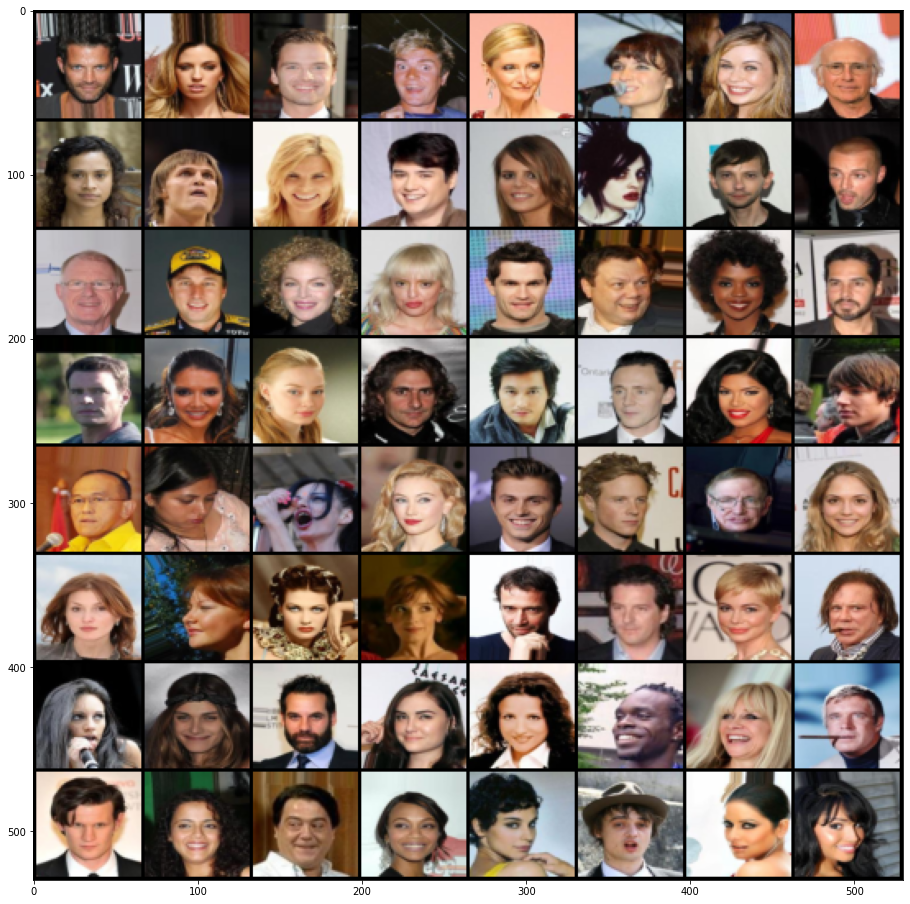

In [209]:
### Scaling image to [-1, 1] range ###
def scale(img, feature_range=(-1, 1)):    
    # Assuming img is scaled in [0, 1] range
    # scale x by feature range
    x = img * (feature_range[1] - feature_range[0]) + feature_range[0]
    return x

### Show sample image data ###
data_iter = iter(dataloader)
images, _ = data_iter.next()
fig, ax = plt.subplots(figsize=(16, 16))
    
ax.imshow(np.transpose(vutils.make_grid(images[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Create the models

In [210]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, filters, kernel_size=4, stride=2, padding=1, bias=False) # Size / 2 = 32
        self.conv2 = nn.Conv2d(filters, filters*2, kernel_size=4, stride=2, padding=1, bias=False) # Size / 4 = 16
        self.norm2 = nn.BatchNorm2d(filters*2)
        self.conv3 = nn.Conv2d(filters*2, filters*4, kernel_size=4, stride=2, padding=1, bias=False) # Size / 8 = 8
        self.norm3 = nn.BatchNorm2d(filters*4)
        self.conv4 = nn.Conv2d(filters*4, filters*8, kernel_size=4, stride=2, padding=1, bias=False) # Size /8 = 8
        self.norm4 = nn.BatchNorm2d(filters*8)
        self.fc    = nn.Linear(filters*8*4*4, 1)
        self.sig   = nn.Sigmoid()
        
    def forward(self, inputs):
        out = F.leaky_relu(self.conv1(inputs), 0.2)
        out = F.leaky_relu(self.norm2(self.conv2(out)), 0.2)
        out = F.leaky_relu(self.norm3(self.conv3(out)), 0.2)
        out = F.leaky_relu(self.norm4(self.conv4(out)), 0.2)
        
        # flatten
        out = out.view(-1, filters*8*4*4)
        out = self.fc(out)
        out = self.sig(out)
        
        return out

D = Discriminator().cuda()
D(G(torch.randn(batch_size, LATENT_DIM).cuda()).cuda()).shape

torch.Size([64, 1])

In [213]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc     = nn.Linear(LATENT_DIM, filters*8*4*4)
        self.tconv1 = nn.ConvTranspose2d(filters*8, filters*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm1  = nn.BatchNorm2d(filters*4)
        self.tconv2 = nn.ConvTranspose2d(filters*4, filters*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm2  = nn.BatchNorm2d(filters*2)
        self.tconv3 = nn.ConvTranspose2d(filters*2, filters, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm3  = nn.BatchNorm2d(filters)
        self.tconv4 = nn.ConvTranspose2d(filters, 3, kernel_size=4, stride=2, padding=1, bias=False)
        
    def forward(self, inputs):
        out = self.fc(inputs)
        out = out.view(-1, filters*8, 4, 4)
        out = F.relu(self.norm1(self.tconv1(out)))
        out = F.relu(self.norm2(self.tconv2(out)))
        out = F.relu(self.norm3(self.tconv3(out)))
        out = self.tconv4(out)
        out = torch.tanh(out)
        
        return out
 
G = Generator().cuda()
z = torch.randn(batch_size, LATENT_DIM).cuda()
G(z).shape

torch.Size([64, 3, 64, 64])

# Initialize parameters of the network

In [214]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

D.apply(weights_init)
G.apply(weights_init)

Generator(
  (fc): Linear(in_features=128, out_features=8192, bias=True)
  (tconv1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

# Start training

In [215]:
# params
lr         = 0.0002
beta1      = 0.5
beta2      = 0.999
epochs     = 1000
batch_size = 64
train_gpu  = False

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

# Create criterions for the discriminator D and generator G
bce   = nn.BCELoss()
zeros = torch.zeros(batch_size, 1)
ones  = torch.ones(batch_size, 1) * 0.9 # smooth labels

def generate_img(image_list):
    grid_size = 4
    final_img = None
    hor_imgs = []
    
    image_list = (image_list + 1.0) / 2.0
    image_list = image_list.cpu().detach().numpy()
    for i in range(0, len(image_list), grid_size):
        img1 = np.transpose(image_list[i], (1, 2, 0))
        img2 = np.transpose(image_list[i+1], (1, 2, 0))
        img3 = np.transpose(image_list[i+2], (1, 2, 0))
        img4 = np.transpose(image_list[i+3], (1, 2, 0))

        hor_img = cv2.hconcat([img1, img2, img3, img4])
        hor_imgs.append(hor_img)
            
    final_img = cv2.vconcat([hor_imgs[0], hor_imgs[1], hor_imgs[2], hor_imgs[3]])
    return final_img

def generate_gif(image_list):
    with imageio.get_writer('images/output.gif', mode='I') as writer:
        for image in image_list:
            image = imageio.core.util.Array(image)
            writer.append_data(image)
    
if(torch.cuda.is_available()):
    print('[INFO] Training with GPU ... ')
    train_gpu = True
    G.cuda()
    D.cuda()
    zeros = zeros.cuda()
    ones = ones.cuda()
    
sample_z = torch.randn(batch_size, LATENT_DIM)
if(train_gpu) : sample_z = sample_z.cuda()
sample_outputs = []

for epoch in range(epochs):
    d_losses = []
    g_losses = []
    
    with tqdm(total=len(dataloader.dataset)//batch_size, file=sys.stdout) as pbar:
        for batch_id, (real_images, _) in enumerate(dataloader):
            ### Train discriminator phase ###
            zeros = torch.zeros(real_images.shape[0], 1).cuda()
            ones  = torch.ones(real_images.shape[0], 1).cuda() # smooth labels

            d_optimizer.zero_grad()
            D.train() # turn discriminator to training mode
            G.eval() # turn generator to evaluation mode
            # Generate fake images
            z = torch.randn(batch_size, LATENT_DIM)
            if(train_gpu):
                real_images = real_images.cuda()
                z = z.cuda()

            fake_images = G(z)
            D_fake = D(fake_images)
            D_real = D(real_images)

            d_fake_loss = bce(D_fake, zeros)
            d_real_loss = bce(D_real, ones)
            d_loss = d_fake_loss + d_real_loss 
            d_loss.backward()
            #d_fake_loss.backward()
            #d_real_loss.backward()
            d_optimizer.step()

            ### Train generator phase ###
            g_optimizer.zero_grad()
            D.eval() # turn discriminator to evaluation mode
            G.train() # turn generator to training mode

            z = torch.randn(batch_size, LATENT_DIM)

            if(train_gpu):
                z = z.cuda()

            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = bce(D_fake, os)
            g_loss.backward()
            g_optimizer.step()

            d_losses.append(d_loss.cpu().detach().numpy())
            g_losses.append(g_loss.cpu().detach().numpy())

            if((batch_id+1) % 150 == 0):
                print('    BATCH #%d, D loss = %.5f, G loss = %.5f' % (batch_id, d_loss, g_loss))

            if((batch_id + 1) % 50 == 0):
                sample_output = np.transpose(vutils.make_grid(G(sample_z)[:16], padding=2, normalize=True).cpu().detach().numpy(),(1,2,0))
                sample_output = (sample_output * 255.0).astype(np.uint8)
                sample_outputs.append(sample_output)
                generate_gif(sample_outputs)
                os.system('clear')
                
            pbar.update(1) # update progress bar
        
    mean_d_loss = np.array(d_losses).mean()
    mean_g_loss = np.array(g_losses).mean()
    print('EPOCH #[%d/%d], D loss = %.5f, G loss = %.5f' % (epoch, epochs, mean_d_loss, mean_g_loss))
        

[INFO] Training with GPU ... 
  6%|▋         | 203/3165 [00:14<03:36, 13.66it/s]


KeyboardInterrupt: 